# Description

**Mô tả bài toán:** Có một lượng lớn khoảng sản dưới lòng đất như dầu, than, muối,...Nhưng rất khó để biết được nơi nào chưa lượng lớn khoảng sản. Như với muối thì cần có các chuyên gia để phân tích các ảnh địa chấn. Nhưng kết quả đó vẫn còn có tính chủ quan của con người nên cần một hệ thống để phân tích và cùng đưa ra dự đoán.  

**Input:** Ảnh địa chấn của khu vựa cần phần tích  


**Output:** Mask dự đoán các khu vực trong ảnh. Để submmit thì cần chuyển mask thành chuỗi [rle](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)  


**Dataset:**
* train gồm 4000 ảnh địa chấn và 4000 mask tương ứng
* test 18000 ảnh cần dự đoán
* train.csv 
> *id:* tên ảnh  
 *rle_mask:* chuỗi rle từ mask của ảnh 
 
* depths.csv
> *id:* tên ảnh  
 *z:* độ sâu pixel chính giữa ảnh 

* sample_submission.csv
> *id:* tên ảnh  
 *rle-mask:* chuỗi rle cần dự đoán của ảnh 



# Import library

In [ ]:
import numpy as np
# from math import floor
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import  Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, concatenate, Dropout, BatchNormalization, Activation, Input, Add
    
from keras import models, layers, callbacks, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import load_img, img_to_array

# Config

**Vấn đề:** Thiết lập các đường dẫn và tham số cần sử dụng  
**Cách làm:** 

In [ ]:
# Thư mục gốc
ROOT_DATA_DIR = '../input/tgs-salt-data/'

# Thư mục chứa mask train
TRAIN_MASK_DIR = ROOT_DATA_DIR + 'train/masks/'
# Thư mục chứa ảnh train
TRAIN_IMAGE_DIR = ROOT_DATA_DIR + 'train/images/'

# thư mục chứa ảnh test
TEST_IMAGE_DIR = ROOT_DATA_DIR + 'test/images/'

# Load data

**Vấn đề:** Đọc các file csv  
**Cách làm:** Dùng hàm read_csv() để đọc file vào bộ nhớ

In [ ]:
train_df = pd.read_csv('../input/tgs-salt-identification-challenge/train.csv')
test_df = pd.read_csv('../input/tgs-salt-identification-challenge/sample_submission.csv')

depths_df = pd.read_csv(ROOT_DATA_DIR + 'depths.csv')

**Vấn đề:** Hiển thị thông tin trong mỗi bảng  
**Cách làm:**
* In ra 5 dòng đầu của mỗi bảng
* In ra info của mỗi bảng 

In [ ]:
train_df.head()

In [ ]:
train_df.info()

**Nhận xét:**  
* Có gần 1600 ảnh(khoảng 40%) ảnh là hoàn toàn không có muối
* Có 1 số ảnh có chứa muối nhưng tỉ lệ vô cùng ít không có giá trị phân loại như ảnh ở dòng 3 chỉ có duy nhất 1 pixel chứa muối

In [ ]:
depths_df.head()

In [ ]:
depths_df.info()

**Nhận xét:**
* Bảng chứa thông tin độ sâu của cả tập train và test

**Vấn đề:** Phân loại ảnh theo mức độ chứa muối  
**Cách làm:** 
* Tính tổng số pixel chứa muối rồi chia cho tổng số pixel của ảnh
* Làm tròn tỉ lệ tính được đến chữ số thập phân thứ nhất

In [ ]:
def get_coverage(rle_mask):
    
    if pd.isna(rle_mask): # ảnh không có muối - rle_mask rỗng

        return 0
    
    else: # ảnh có muối        
        arr = rle_mask.split() # cắt chuỗi rle thành list        
        coverage = sum(int(x) for x in arr[1::2]) / (101**2) # cộng tổng các pixel (số ở vị trí lẻ)

        return np.round(coverage,1)

train_df['coverage'] = train_df['rle_mask'].map(get_coverage)
train_df.head()

In [ ]:
train_df.value_counts('coverage', sort=False, ascending=True)

In [ ]:
train_df.value_counts('coverage', sort=False, ascending=True).plot(kind ='bar', title='Phân bố mật độ muối trong ảnh' , rot=0);

**Nhận xét:** 
* Gần 50% số ảnh là chứa dưới 5% muối. Trong đó khoảng 40% là hoàn toàn không chứa muối
* Bộ dữ liệu không cân bằng
* Không nên dùng accuracy để đánh giá model  
 => Sử dụng hàm IoU được tuỳ chình lại của cuộc thi


* Nên sử dụng các phép biến đổi để tăng số lượng ảnh có chứa muối




**Vấn đề:** Load ảnh và mask của tập train  
**Cách làm:**
* Load từng ảnh theo thứ tự xuất hiện trong file train.csv
* Ảnh là ảnh chụp sóng và mask chỉ có 2 nhãn nên chọn load ở chế độ màu grayscale

In [ ]:
# Load image
train_imgs = [load_img(TRAIN_IMAGE_DIR + image_name + '.png', color_mode='grayscale') for image_name in tqdm(train_df['id'])]
train_masks = [load_img(TRAIN_MASK_DIR + image_name + '.png', color_mode='grayscale') for image_name in tqdm(train_df['id'])]

# Chuyển từ PIL sang np và chuẩn hoá
train_imgs = [img_to_array(img, dtype=np.uint8)/255 for img in train_imgs]
train_masks = [img_to_array(mask, dtype=np.uint8)//255 for mask in train_masks]

**Vấn đề:** visualize ảnh và mask của tập train  
**Cách làm:**
* In các ảnh và mash tương ứng
* Vẽ chồng ảnh và mask

In [ ]:
# def show_img_mask():
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20));
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('Mask', size='large')
axes[0][2].set_title('Overlay', size='large')
for row in range(5):
    # Image
#     axes[row][0].axis('off')
    axes[row][0].imshow(train_imgs[row],cmap="gray")

    # Mask
#     axes[row][1].axis('off')
    axes[row][1].imshow(train_masks[row],cmap="gray")

    # Overlay
#     axes[row][2].axis('off')
    axes[row][2].imshow(train_imgs[row],cmap="gray")
    axes[row][2].imshow(train_masks[row], alpha=0.2, cmap="Reds")
    axes[row][2].contour(train_masks[row].squeeze(), colors='red')

# Split train-valid

**Vấn đề:** Chia train và valid  
**Cách làm** 
* Sử dụng hàm train_test_split
* Chia theo mức chứa muối
* Chia train:valid theo tỉ lệ 8:2
* Đưa list ảnh về ma trận dạng (N,H,W,C)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split( np.array(train_imgs), 
                                                      np.array(train_masks), 
                                                      test_size = 0.2, 
                                                      stratify=train_df.coverage, 
                                                      random_state=1234)

# Augmentation

**Vấn đề:** Augument ảnh train  
**Cách làm:**
* Lật trái phải

In [ ]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# Build Model

## Hàm đánh giá

**Vấn đề:** Định nghĩa hàm đánh giá  
**Cách làm:** 
* Tính iou
* So sánh iou với từng threshold trong khoảng 0.5 đến 0.95 bước 0.05
* Tính mean của kết quả so sánh

In [ ]:
def iou_vector(trues, preds):
    SMOOTH = 1e-10
    batch_size = trues.shape[0]
    
    metric = []

    for idx in range(batch_size):

        true, pred = trues[idx], preds[idx]

        # True positives
        intersection = np.logical_and(true, pred)
        # True positives, false negatives and false positives 
        union = np.logical_or(true,pred)
        
        iou = (np.sum(intersection) + SMOOTH) / (np.sum(union) + SMOOTH)
        
        # so sánh iou với các mức threshold
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
            
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    
    return tf.py_function(iou_vector, [label, pred>0.5], tf.float64)

## Build ResUnet

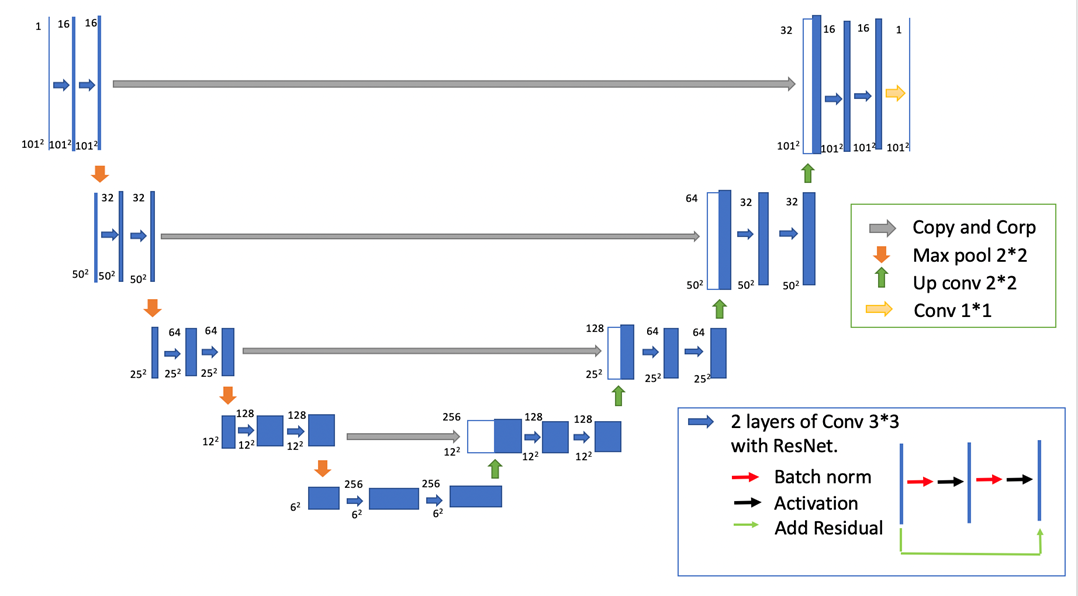

**Vấn đề:** Định nghĩa các block  
**Cách làm:** Dựng các block convolution và residual  

Nguồn: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385v1.pdf)

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = convolution_block(blockInput, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    x = Activation('relu')(x)
    return x

**Vấn đề:** Định nghĩa model ResUnet  
**Cách làm:**
* Đặt các tham số như số feature khởi đầu, dropout
* Phần Encoder giảm chiều dài, chiều rộng và tăng chiều sâu bằng các lớp conv và pooling
* Phần Decoder khôi phục lại kích thước ban đầu đồng thời nối với các layer tương ứng ở phần encoder để giảm thiểu mất mát
* Thay các conv block của [Unet](https://arxiv.org/pdf/1505.04597.pdf) thành các residual block

In [ ]:
def build_model(input_shape):
    #
    start_feature = 32    
    DropoutRatio = 0.5
    skip_connections = []
    hyper_columns = []
    
    # Input
    inputs = Input(input_shape)
    x = inputs

    # Encoder
    for i in range(4):
        x = convolution_block(x, start_feature*(2**i), 3)
        x = residual_block(x, start_feature*(2**i))
        x = residual_block(x, start_feature*(2**i))

        skip_connections.append(x)

        x = MaxPooling2D((2,2))(x)


    # Midder
    x = convolution_block(x, start_feature*(2**4), 3)
    x = residual_block(x, start_feature*(2**4))
    x = residual_block(x, start_feature*(2**4))

    # Decoder
    for i in reversed(range(4)):
        if x.shape[2]*2 != skip_connections[i].shape[2]:
            x = Conv2DTranspose(start_feature*(2**i), (3,3), strides=(2, 2), padding='valid')(x)
        else:
            x = Conv2DTranspose(start_feature*(2**i), (3,3), strides=(2, 2), padding='same')(x)

        x = concatenate([x, skip_connections[i]])
        x = Dropout(DropoutRatio)(x)

        x = convolution_block(x, start_feature*(2**i), 3)
        x = residual_block(x, start_feature*(2**i))
        x = residual_block(x, start_feature*(2**i))


    # Output
    output = Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)

    model = Model(inputs, output)

    return model

## Compile model

**Vấn đề:** Build model  
**Cách làm:** 
* Dựng model vừa định nghĩa với ảnh input là 101\*101\*1
* Vì là bài toán segmentation nên hàm loss chọn binary_crossentropy
* Hàm tối ưu chọn Adam 
* Hàm đánh giá đã định nghĩa ở trên

In [ ]:
model = build_model((101,101,1))
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=[my_iou_metric])

model.summary()

# Train model

**Vấn đề:** Train model  
**Cách làm:**
* Train model với 100 epochs và 50 steps/epoch
* Dừng sớm model nếu sau 15 epochs không cải thiện điểm của tập valid
* Giảm learing rate đi 1/2 nếu sau 5 epochs không cải thiện điểm của tập valid

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
# model_checkpoint = ModelCheckpoint("best.model", monitor='val_my_iou_metric', mode='max',
#                                    save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5,
                              min_lr=0.0001, verbose=1)

epochs = 100
steps_per_epoch = 50

history = model.fit(x_train, y_train,
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    steps_per_epoch = steps_per_epoch, 
                    callbacks = [early_stopping, reduce_lr],
                    verbose = 1)

**Vấn đề:** Xem kết quả train  
**Cách làm:** In giá trị loss, metric sau mỗi epochs 

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5));
ax_loss.set_ylim(0,1)
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
# ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
# ax_score.legend();

# Predict

## Predict

**Vấn đề:** Đánh giá trực quan hoá kết quả  
**Cách làm:** 
* Với từng ảnh, in ra ảnh, mask, predict mask và hình so sánh

In [ ]:
# Predict valid
pred_valid = model.predict(x_valid[:5])

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 20));
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('True mask', size='large')
axes[0][2].set_title('Predict mask', size='large')
axes[0][3].set_title('Overlay', size='large')
for row in range(5):
    # Image
    axes[row][0].axis('off')
    axes[row][0].imshow(x_valid[row],cmap="gray")

    # True mask
    axes[row][1].axis('off')
    axes[row][1].imshow(y_valid[row],cmap="gray")

    # Predict mask
    axes[row][2].axis('off')
    axes[row][2].imshow(np.round(pred_valid[row]),cmap="gray")

    # Overlay
    axes[row][3].axis('off')
    axes[row][3].imshow(x_valid[row],cmap="gray")
    axes[row][3].imshow(y_valid[row], alpha=0.2, cmap="Reds")
    axes[row][3].contour(y_valid[row].squeeze(), colors='red')
    axes[row][3].imshow(np.round(pred_valid[row]), alpha=0.2, cmap="Blues")
    axes[row][3].contour(np.round(pred_valid[row]).squeeze(), colors='blue')

**Nhận xét:**

**Vấn đề:** Predict ảnh test  
**Cách làm:** 
* Load ảnh test
* predict với model vừa train

In [ ]:
test_imgs = [load_img(TEST_IMAGE_DIR + image_name + '.png', color_mode='grayscale') for image_name in tqdm(test_df['id'])]
test_imgs = np.array([img_to_array(img, dtype=np.uint8)/255 for img in test_imgs])

pred_test = model.predict(test_imgs, verbose=1)

In [ ]:
test_flip = np.array([np.fliplr(x) for x in test_imgs])
pred_test_flip = model.predict(test_flip, verbose=1)

pred_test += np.array([ np.fliplr(x) for x in pred_test_flip])
pred_test/=2

## Xử lý output

**Vấn đề:** Định nghĩa hàm chuyển mask thành chuỗi rle  
**Cách làm:** 
* Chuyển các pixel của mask thành chuỗi theo thứ tự từ trên xuống dưới, từ trái qua phải
* Thêm số 0 vào đầu và cuối dãy
* So sánh để tìm ra vị trí khác nhau của dãy pixels[1:] và pixel[:-1]
* Dãy thu được là các cặp vị trí đầu và cuối của dãy các số 1 liên tiếp
* Thay số ở vị trí lẻ bằng hiệu của nó với số liền trước
* Chuyển array về string

In [ ]:
def mask2rle(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**Vấn đề:** Chuyển giá trị pred về rle mask  
**Cách làm:** 
* Cho pred chạy qua threshold để chuyển về dạng mask chỉ chứa 0 và 1
* Chuyển mask thu được thành chuỗi rle 

In [ ]:
rle_masks = [mask2rle(np.round(x)) for x in pred_test]

## Submission

**Vấn đề:** Chuẩn bị file submission  
**Cách làm:** 
* Thêm rle_masks vừa dự đoán vào file submission
* Lưu lại file submission


In [ ]:
test_df["rle_mask"] = rle_masks
test_df.to_csv("submission.csv", index=False)